<a href="https://colab.research.google.com/github/bhavyadora2002/VR_Project1_BhavyaDora_MT2024045/blob/main/vr_mini_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# c. Region Segmentation Using Traditional Techniques (3 Marks)
## i. Implement a region-based segmentation method (e.g., thresholding, edge detection) to segment the mask regions for faces identified as "with mask."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing Images: 100%|██████████| 9403/9403 [51:13<00:00,  3.06img/s]


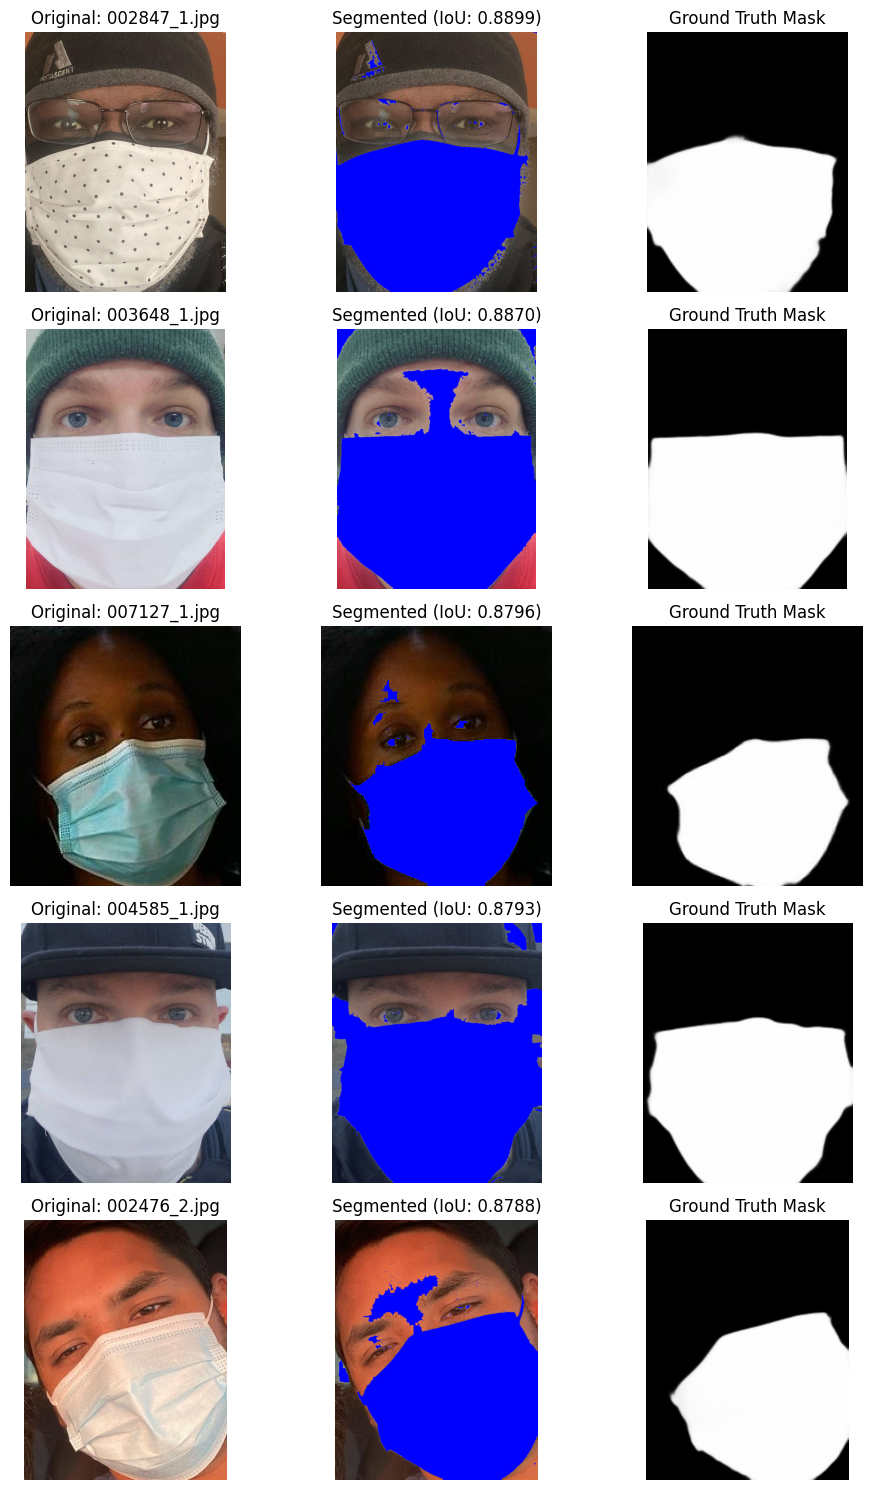


Mean IoU: 0.3226


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

input_folder = "/content/drive/MyDrive/face_crop/"
ground_truth_folder = "/content/drive/MyDrive/face_crop_segmentation/"

image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

top_results = []
mean_iou_sum = 0
image_count = 0


for img_file in tqdm(image_files, desc="Processing Images", unit="img"):
    image_path = os.path.join(input_folder, img_file)
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5,5), 0)

    edges = cv2.Canny(blurred, 50, 150)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)

    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    gt_path = os.path.join(ground_truth_folder, img_file)
    if os.path.exists(gt_path):
        gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask, (mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_NEAREST)  # Already binary
        pred_mask = mask > 127

        iou = compute_iou(pred_mask, gt_mask)
        mean_iou_sum += iou
        image_count += 1

        if len(top_results) < 5:
            top_results.append((iou, img_file, image, pred_mask, gt_mask))
        else:
            min_iou = min(top_results, key=lambda x: x[0])
            if iou > min_iou[0]:
                top_results.remove(min_iou)
                top_results.append((iou, img_file, image, pred_mask, gt_mask))

top_results.sort(reverse=True, key=lambda x: x[0])

plt.figure(figsize=(10, 3 * len(top_results)))

for i, (iou, img_file, original, pred_mask, gt_mask) in enumerate(top_results):
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    overlay = original_rgb.copy()
    overlay[pred_mask > 0] = [0, 0, 255]

    plt.subplot(len(top_results), 3, i * 3 + 1)
    plt.imshow(original_rgb)
    plt.title(f"Original: {img_file}")
    plt.axis("off")

    plt.subplot(len(top_results), 3, i * 3 + 2)
    plt.imshow(overlay)
    plt.title(f"Segmented (IoU: {iou:.4f})")
    plt.axis("off")

    plt.subplot(len(top_results), 3, i * 3 + 3)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

if image_count > 0:
    mean_iou = mean_iou_sum / image_count
    print(f"\nMean IoU: {mean_iou:.4f}")


## ii. Visualize and evaluate the segmentation results.

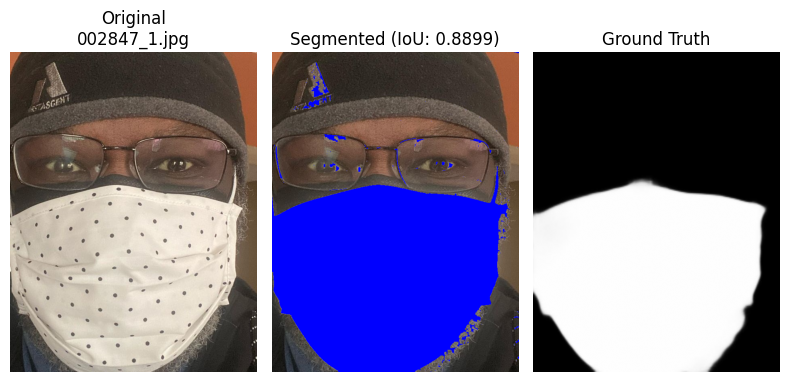

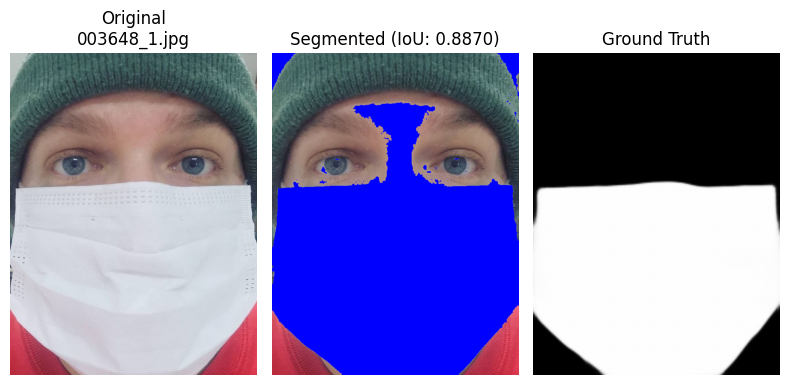

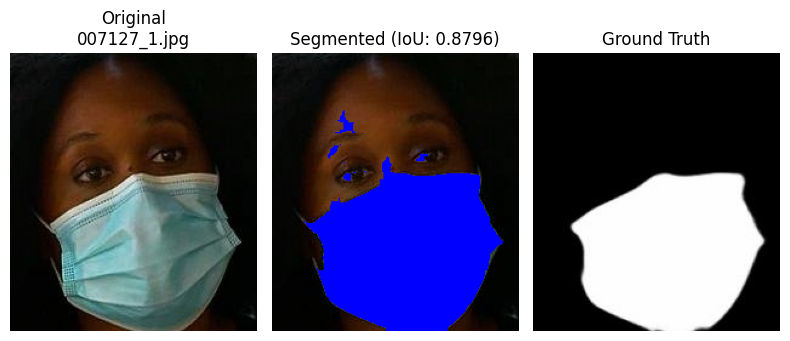

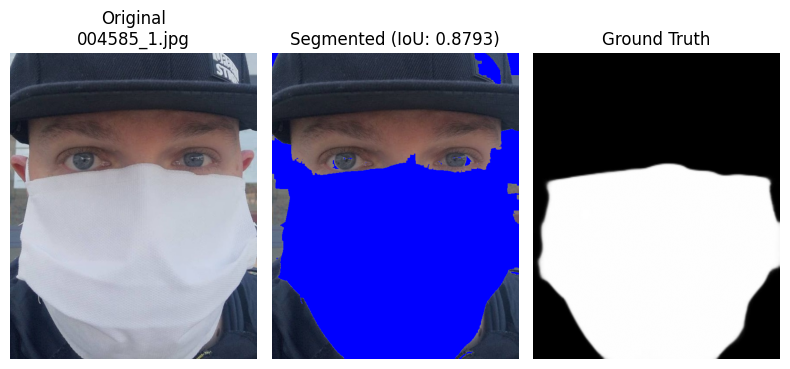

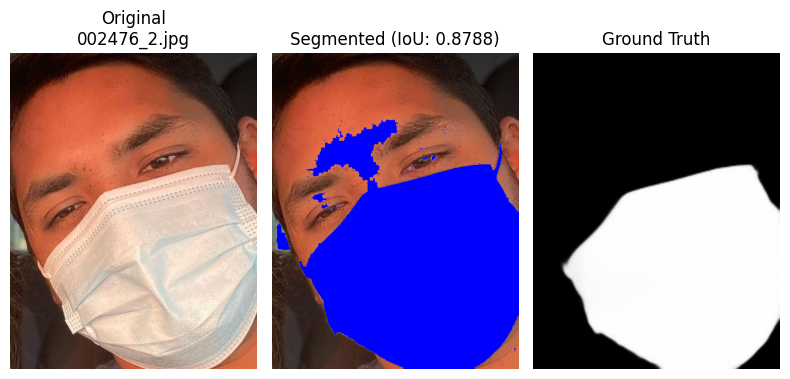

In [ ]:
for i, (iou, img_file, original, pred_mask, gt_mask) in enumerate(top_results):
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    overlay = original_rgb.copy()
    overlay[pred_mask > 0] = [0, 0, 255]  # Red overlay for segmented mask

    plt.figure(figsize=(8, 4))  # Smaller figure for each result

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{img_file}")
    plt.axis("off")

    # Segmented Mask
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title(f"Segmented (IoU: {iou:.4f})")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()  # Show each result in a separate output cell


Processing Images: 100%|██████████| 9403/9403 [1:50:54<00:00,  1.41it/s]


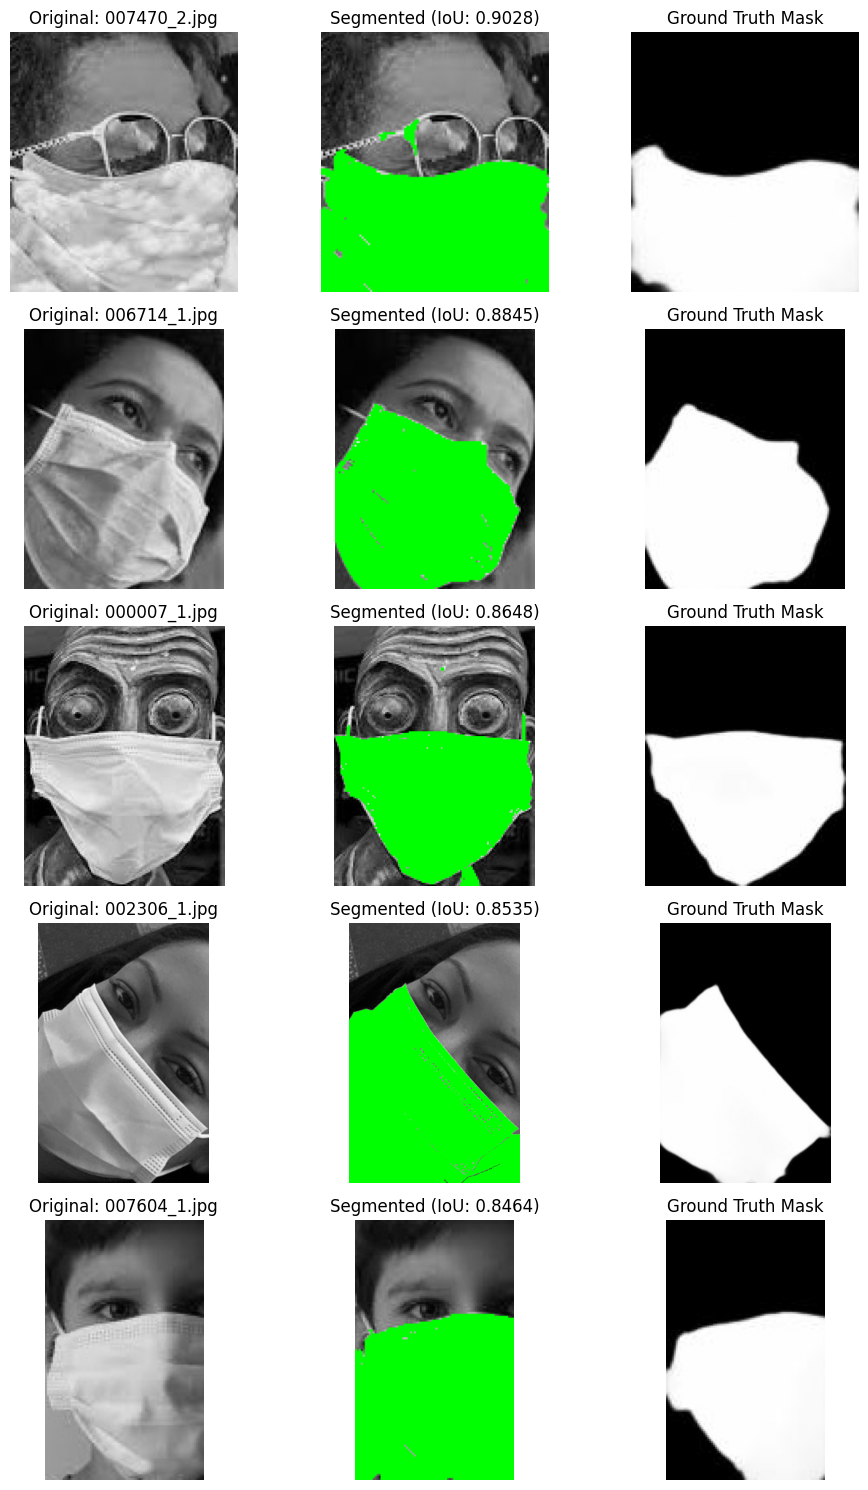

✅ Segmentation completed and top 5 results displayed!


In [ ]:
import cv2
import numpy as np
import os
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm

input_folder = "/content/drive/MyDrive/face_crop/"
gt_folder = "/content/drive/MyDrive/face_crop_segmentation/"

THRESHOLD = 20


def compute_iou(pred_mask, gt_mask):
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0


def region_growing(image, seed_points, threshold):
    height, width = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)

    stack = list(seed_points)

    while stack:
        x, y = stack.pop()

        if segmented[y, x] == 0:
            segmented[y, x] = 255

            neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

            for nx, ny in neighbors:
                if 0 <= nx < width and 0 <= ny < height and segmented[ny, nx] == 0:
                    intensity_diff = abs(int(image[ny, nx]) - int(image[y, x]))
                    if intensity_diff < threshold:
                        stack.append((nx, ny))

    return segmented

def process_image(img_file):
    image_path = os.path.join(input_folder, img_file)
    gt_path = os.path.join(gt_folder, img_file)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None or not os.path.exists(gt_path):
        return None

    num_seeds = 5
    sorted_pixels = np.dstack(np.unravel_index(np.argsort(image.ravel()), image.shape))[0][-num_seeds:]
    seed_points = [(x, y) for y, x in sorted_pixels]

    segmented = region_growing(image, seed_points, THRESHOLD)

    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (segmented.shape[1], segmented.shape[0]), interpolation=cv2.INTER_NEAREST)

    pred_mask = segmented > 127
    iou = compute_iou(pred_mask, gt_mask)

    return (iou, img_file, image, segmented, gt_mask)

if __name__ == "__main__":
    image_files = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

    num_workers = multiprocessing.cpu_count()
    with multiprocessing.Pool(num_workers) as pool:
        results = list(tqdm(pool.imap_unordered(process_image, image_files), total=len(image_files), desc="Processing Images"))

    valid_results = [res for res in results if res is not None]
    valid_results.sort(reverse=True, key=lambda x: x[0])

    top_results = valid_results[:5]

    plt.figure(figsize=(10, 3 * len(top_results)))

    for i, (iou, img_file, original, pred_mask, gt_mask) in enumerate(top_results):
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        overlay = original_rgb.copy()
        overlay[pred_mask > 0] = [0, 255, 0]

        plt.subplot(len(top_results), 3, i * 3 + 1)
        plt.imshow(original_rgb)
        plt.title(f"Original: {img_file}")
        plt.axis("off")

        plt.subplot(len(top_results), 3, i * 3 + 2)
        plt.imshow(overlay)
        plt.title(f"Segmented (IoU: {iou:.4f})")
        plt.axis("off")

        plt.subplot(len(top_results), 3, i * 3 + 3)
        plt.imshow(gt_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(" Segmentation completed and top 5 results displayed!")
